In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
import math
import torch
import random
import wandb
import numpy as np
import hydra
from omegaconf import OmegaConf
import gym, d4rl
import d4rl.gym_mujoco
import sys
sys.path.append('./dppo')
 
from stable_baselines3 import SAC, DSRL
from stable_baselines3.common.callbacks import CheckpointCallback, BaseCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv
from env_utils import DiffusionPolicyEnvWrapper, ObservationWrapperRobomimic, ObservationWrapperGym, ActionChunkWrapper, make_robomimic_env
from utils import load_base_policy, load_offline_data, collect_rollouts, LoggingCallback

OmegaConf.register_new_resolver("eval", eval, replace=True)
OmegaConf.register_new_resolver("round_up", math.ceil)
OmegaConf.register_new_resolver("round_down", math.floor)

try:
    # If using IPython/Jupyter, this command gets the path of the notebook file
    notebook_path = os.path.abspath(globals().get('__file__', os.getcwd()))
    base_path = os.path.dirname(notebook_path)
except NameError:
    # Fallback for when __file__ is truly unavailable (typical notebook cell)
    base_path = os.getcwd()
path_to_diffusion_policy = os.path.join("..", "diffusion_policy")

# Ensure the path is absolute before adding, to avoid confusion for Python
abs_path_to_diffusion_policy = os.path.abspath(path_to_diffusion_policy)

if abs_path_to_diffusion_policy not in sys.path:
    sys.path.append(abs_path_to_diffusion_policy)
    print(f"Added {abs_path_to_diffusion_policy} to sys.path.")

# Test the import
try:
    import diffusion_policy
    print("Module 'diffusion_policy' is now importable!")
except ModuleNotFoundError as e:
    print(f"ERROR: Module still not found. Please double-check the path. Error: {e}")

from hydra import compose, initialize

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
No module named 'mjrl'
No module named 'flow'
No module named 'carla'
pybullet build time: Jan 29 2025 23:20:52


Added /home/vyseian/GitHub/diffusion_policy to sys.path.
Module 'diffusion_policy' is now importable!


In [2]:
config_dir = "cfg/robomimic"

with initialize(config_path=config_dir, version_base=None):
    cfg_dppo = compose(config_name="dsrl_square.yaml")

OmegaConf.resolve(cfg_dppo)

with initialize(config_path=config_dir, version_base=None):
    cfg_dp = compose(config_name="dsrl_square_dp_low_dim.yaml")

OmegaConf.resolve(cfg_dp)

In [3]:
random.seed(cfg_dppo.seed)
np.random.seed(cfg_dppo.seed)
torch.manual_seed(cfg_dppo.seed)

In [4]:
env_dppo = make_robomimic_env(env=cfg_dppo.env_name, 
                normalization_path=cfg_dppo.normalization_path, 
                low_dim_keys=cfg_dppo.env.wrappers.robomimic_lowdim.low_dim_keys, 
                dppo_path=cfg_dppo.dppo_path, 
                abs_action=cfg_dppo.env.wrappers.robomimic_lowdim.get("abs_action", False),)
env_dppo = ObservationWrapperRobomimic(env_dppo, reward_offset=cfg_dppo.env.reward_offset)
env_dppo = ActionChunkWrapper(env_dppo, cfg_dppo, max_episode_steps=cfg_dppo.env.max_episode_steps)

env_dp = make_robomimic_env(env=cfg_dp.env_name, 
                normalization_path=cfg_dp.normalization_path, 
                low_dim_keys=cfg_dp.env.wrappers.robomimic_lowdim.low_dim_keys, 
                dppo_path=cfg_dp.dppo_path, 
                abs_action=cfg_dp.env.wrappers.robomimic_lowdim.get("abs_action", False),)
env_dp = ObservationWrapperRobomimic(env_dp, reward_offset=cfg_dp.env.reward_offset)
env_dp = ActionChunkWrapper(env_dp, cfg_dp, max_episode_steps=cfg_dp.env.max_episode_steps)

[robosuite WARNING] No private macro file found! (macros.py:53)
[robosuite WARNING] It is recommended to use a private macro file (macros.py:54)
[robosuite WARNING] To setup, run: python /home/vyseian/miniconda3/envs/dsrl/lib/python3.9/site-packages/robosuite/scripts/setup_macros.py (macros.py:55)


Created environment with name NutAssemblySquare
Action size is 7
Created environment with name NutAssemblySquare
Action size is 7


In [5]:
base_policy_dppo = load_base_policy(cfg_dppo)

base_policy_dp = load_base_policy(cfg_dp)

Loading DP checkpoint from: /home/vyseian/data/low_dim_square_mh_diffusion_policy_cnn_higher_var_latest.ckpt
Using state_dict from state_dicts['ema_model']
Loaded weights into DiffusionUnetLowdimPolicy(
  (model): ConditionalUnet1D(
    (mid_modules): ModuleList(
      (0-1): 2 x ConditionalResidualBlock1D(
        (blocks): ModuleList(
          (0-1): 2 x Conv1dBlock(
            (block): Sequential(
              (0): Conv1d(1024, 1024, kernel_size=(5,), stride=(1,), padding=(2,))
              (1): GroupNorm(8, 1024, eps=1e-05, affine=True)
              (2): Mish()
            )
          )
        )
        (cond_encoder): Sequential(
          (0): Mish()
          (1): Linear(in_features=302, out_features=2048, bias=True)
          (2): Rearrange('batch t -> batch t 1')
        )
        (residual_conv): Identity()
      )
    )
    (diffusion_step_encoder): Sequential(
      (0): SinusoidalPosEmb()
      (1): Linear(in_features=256, out_features=1024, bias=True)
      (2): Mis

In [6]:
post_linear_modules = None
if cfg_dppo.train.use_layer_norm:
    post_linear_modules = [torch.nn.LayerNorm]

net_arch = []
policy_kwargs = dict(
    net_arch=dict(pi=net_arch, qf=net_arch),
    activation_fn=torch.nn.Tanh,
    log_std_init=0.0,
    post_linear_modules=post_linear_modules,
    n_critics=cfg_dppo.train.n_critics,
)

In [7]:
act_steps = getattr(cfg_dppo, "act_steps", None)
action_dim = getattr(cfg_dppo, "action_dim", None)
diffusion_act_dim = (int(act_steps), int(action_dim))
print(diffusion_act_dim)

model_dppo = DSRL(
    "MlpPolicy",
    env_dppo,
    learning_rate=cfg_dppo.train.actor_lr,
    buffer_size=10000000,      # Replay buffer size
    learning_starts=1,    # How many steps before learning starts (total steps for all env combined)
    batch_size=cfg_dppo.train.batch_size,
    tau=cfg_dppo.train.tau,                # Target network update rate
    gamma=cfg_dppo.train.discount,               # Discount factor
    train_freq=cfg_dppo.train.train_freq,             # Update the model every train_freq steps
    gradient_steps=cfg_dppo.train.utd,         # How many gradient steps to do at each update
    action_noise=None,        # No additional action noise
    optimize_memory_usage=False,
    ent_coef="auto" if cfg_dppo.train.ent_coef == -1 else cfg_dppo.train.ent_coef,          # Automatic entropy tuning
    target_update_interval=1, # Update target network every interval
    target_entropy="auto" if cfg_dppo.train.target_ent == -1 else cfg_dppo.train.target_ent,    # Automatic target entropy
    use_sde=False,
    sde_sample_freq=-1,
    tensorboard_log=cfg_dppo.logdir,
    verbose=1,
    policy_kwargs=policy_kwargs,
    diffusion_policy=base_policy_dppo,
    # diffusion_act_dim=(cfg.act_steps, cfg.action_dim),
    diffusion_act_dim=diffusion_act_dim,
    noise_critic_grad_steps=cfg_dppo.train.noise_critic_grad_steps,
    critic_backup_combine_type=cfg_dppo.train.critic_backup_combine_type,
)

act_steps = getattr(cfg_dp.policy, "n_action_steps", None) or getattr(cfg_dp.policy, "horizon", None)
# action_dim = getattr(cfg.policy, "action_dim", None) or getattr(cfg, "action_dim", None)
action_dim = getattr(cfg_dp, "action_dim", None)
diffusion_act_dim = (int(act_steps), int(action_dim))
print(diffusion_act_dim)

model_dp = DSRL(
    "MlpPolicy",
    env_dp,
    learning_rate=cfg_dp.train.actor_lr,
    buffer_size=10000000,      # Replay buffer size
    learning_starts=1,    # How many steps before learning starts (total steps for all env combined)
    batch_size=cfg_dp.train.batch_size,
    tau=cfg_dp.train.tau,                # Target network update rate
    gamma=cfg_dp.train.discount,               # Discount factor
    train_freq=cfg_dp.train.train_freq,             # Update the model every train_freq steps
    gradient_steps=cfg_dp.train.utd,         # How many gradient steps to do at each update
    action_noise=None,        # No additional action noise
    optimize_memory_usage=False,
    ent_coef="auto" if cfg_dp.train.ent_coef == -1 else cfg_dp.train.ent_coef,          # Automatic entropy tuning
    target_update_interval=1, # Update target network every interval
    target_entropy="auto" if cfg_dp.train.target_ent == -1 else cfg_dp.train.target_ent,    # Automatic target entropy
    use_sde=False,
    sde_sample_freq=-1,
    tensorboard_log=cfg_dp.logdir,
    verbose=1,
    policy_kwargs=policy_kwargs,
    diffusion_policy=base_policy_dp,
    # diffusion_act_dim=(cfg.act_steps, cfg.action_dim),
    diffusion_act_dim=diffusion_act_dim,
    noise_critic_grad_steps=cfg_dp.train.noise_critic_grad_steps,
    critic_backup_combine_type=cfg_dp.train.critic_backup_combine_type,
)

(4, 7)
Using cuda device
env class: <class 'env_utils.ActionChunkWrapper'>
gymnasium.Env class: <class 'gymnasium.core.Env'>
MRO: (<class 'env_utils.ActionChunkWrapper'>, <class 'gymnasium.core.Env'>, <class 'typing.Generic'>, <class 'object'>)
Is instance: True
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
env class: <class 'stable_baselines3.common.monitor.Monitor'>
gymnasium.Env class: <class 'gymnasium.core.Env'>
MRO: (<class 'stable_baselines3.common.monitor.Monitor'>, <class 'gymnasium.core.Wrapper'>, <class 'gymnasium.core.Env'>, <class 'typing.Generic'>, <class 'object'>)
Is instance: True
(8, 7)
Using cuda device
env class: <class 'env_utils.ActionChunkWrapper'>
gymnasium.Env class: <class 'gymnasium.core.Env'>
MRO: (<class 'env_utils.ActionChunkWrapper'>, <class 'gymnasium.core.Env'>, <class 'typing.Generic'>, <class 'object'>)
Is instance: True
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
env class: <class 'stabl

In [8]:
obs_dppo, _ = env_dppo.reset()

obs_dppo = np.reshape(obs_dppo, (-1, obs_dppo.shape[-1]))

print(obs_dppo, obs_dppo.shape)

obs_dp, _ = env_dp.reset()

obs_dp = np.reshape(obs_dp, (-1, obs_dp.shape[-1]))

print(obs_dp, obs_dp.shape)

[[-0.32127042 -0.35028129  0.48212825  0.99528199  0.05080063 -0.39399638
   0.3629687   0.00569769  0.10794723 -0.40955555  0.33768635  0.60066106
  -0.11778628  0.02974205  0.55680453  0.78707182 -0.29782654 -0.36584941
  -0.15531963 -0.79597839  0.60168398 -0.152226   -0.89012371]] (1, 23)
[[-0.23989409 -0.38583565  0.51049145  0.99199262  0.03115569 -0.32006431
   0.35143437  0.00569769  0.10794723 -0.39808811  0.169113    0.60066106
  -0.11778628  0.02974205  0.02383408  0.98778053 -0.47951329 -0.2857069
  -0.10294184 -0.98381106  0.1553732  -0.2187854  -0.96725518]] (1, 23)


In [9]:
action_dppo_noise, _ = model_dppo.policy.predict(obs_dppo, None, None, False)

print(action_dppo_noise, action_dppo_noise.shape, action_dppo_noise.mean())

action_dp_noise, _ = model_dp.policy.predict(obs_dp, None, None, False)

print(action_dp_noise, action_dp_noise.shape, action_dp_noise.mean())

[[-0.7377189   0.9933193   0.36764967 -0.8174191   0.283414   -0.0035435
  -0.89140517  0.9844558   0.08359408 -0.97895014 -0.76349604  0.89806557
  -0.83627975 -0.07663804 -0.6828576  -0.9806702  -0.73775995  0.08410263
  -0.9629116  -0.8216054  -0.91794807 -0.3440957  -0.9611072  -0.74991786
  -0.23141247  0.97472453  0.99772346  0.8609446 ]] (1, 28) -0.21313368
[[-0.7209876  -0.53561467 -0.85508865 -0.8811103   0.22316253 -0.6605639
  -0.66299707 -0.7941248   0.15061021 -0.48485005  0.16552842  0.5968112
   0.8628466  -0.01571018 -0.8623848   0.9853697  -0.17170459  0.9055251
  -0.65840805 -0.73096573  0.29060352 -0.3454514   0.19906807  0.06456757
   0.46991718 -0.73615384  0.49137676  0.71302235 -0.20748425  0.38913846
   0.11655009  0.08171415 -0.566775    0.7605748   0.7002442  -0.4329478
   0.26474118  0.4739318   0.15904832 -0.87442356  0.7886547   0.9983654
  -0.18865395 -0.9737464   0.92259634 -0.10012329  0.4266293  -0.90363526
  -0.8077945   0.832641   -0.9188465  -0.34229

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

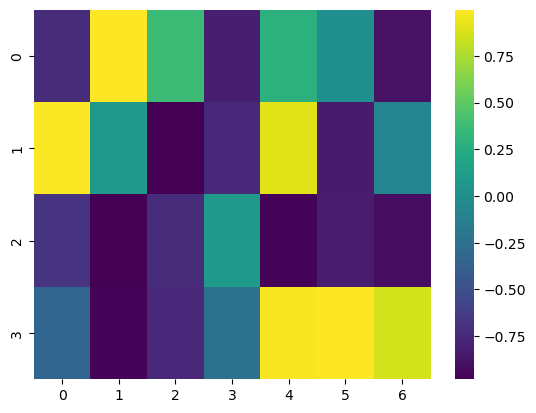

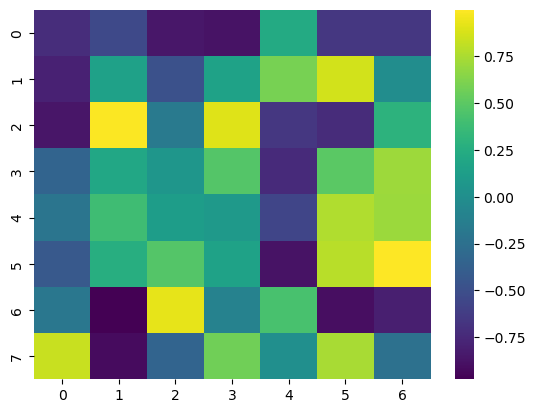

In [11]:
plt.figure()
sns.heatmap(np.reshape(action_dppo_noise, (-1, 7)), cmap='viridis')
plt.show()

plt.figure()
sns.heatmap(np.reshape(action_dp_noise, (-1, 7)), cmap='viridis')
plt.show()

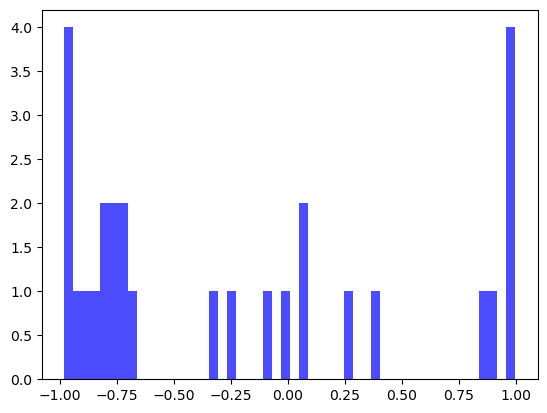

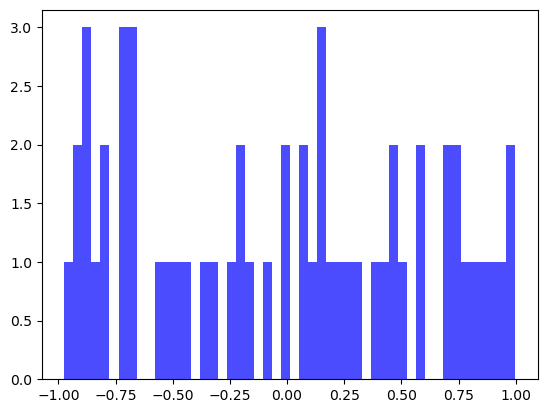

In [12]:
plt.figure()
plt.hist(action_dppo_noise.flatten(), bins=50, color='blue', alpha=0.7)
plt.show()

plt.figure()
plt.hist(action_dp_noise.flatten(), bins=50, color='blue', alpha=0.7)
plt.show()

In [13]:
print(action_dppo_noise.min(), action_dppo_noise.max())
print(action_dp_noise.min(), action_dp_noise.max())

-0.9806702 0.99772346
-0.9737464 0.9983654


In [14]:
action_dppo, _ = model_dppo.predict_diffused(obs_dp, deterministic=True)

action_dp, _ = model_dp.predict_diffused(obs_dppo, deterministic=True)

In [15]:
print(action_dppo, action_dppo.shape, action_dppo.mean())

[[ 2.36345809e-02  1.37735892e-03  2.67959218e-02  3.24817598e-01
   1.68827817e-01  1.85565740e-01 -1.00000000e+00  8.66941363e-02
   8.34671501e-03 -1.10335415e-02  3.77474606e-01  1.74462691e-01
   2.80394638e-03 -1.00000000e+00  8.27452317e-02 -3.21862288e-03
  -3.42257880e-02  3.80631745e-01  1.58324927e-01  9.57592914e-04
  -9.99095440e-01  8.89469087e-02  1.40091171e-03 -2.85123717e-02
   3.77290905e-01  1.45943344e-01  6.57857582e-03 -9.97725546e-01]] (1, 28) -0.051792502


In [16]:
print(action_dp, action_dp.shape, action_dp.mean())

[[ 0.12523423  0.36838788  0.77939534  1.6982539  -1.5157205  -0.2880843
  -0.09904543  0.12472917  0.36838788  0.77939534  1.6295512  -1.598746
  -0.36964208  0.150167    0.18775336  0.36838788  0.77939534  1.5760859
  -1.56038    -0.2546083   0.10761416  0.13829948  0.36838788  0.77939534
   1.5878763  -1.6485426  -0.3646465  -0.01952478  0.1509795   0.36838788
   0.77939534  1.6366756  -1.5730054  -0.36386994 -0.26540402  0.12822275
   0.36838788  0.77939534  1.6003791  -1.5172048  -0.27196223 -0.02877428
   0.141836    0.36838788  0.77939534  1.5931242  -1.6058271  -0.3362087
   0.03406471  0.15506773  0.36838788  0.77939534  1.6119992  -1.6150995
  -0.36381885 -0.00618175]] (1, 56) 0.1409622


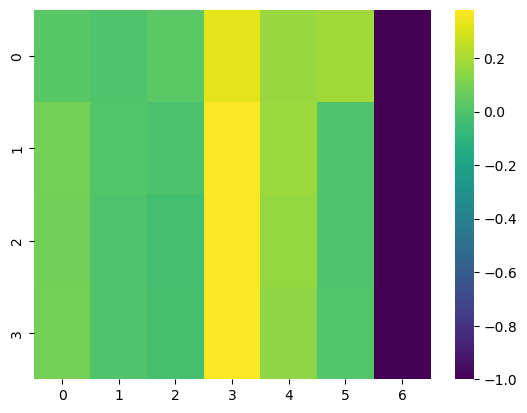

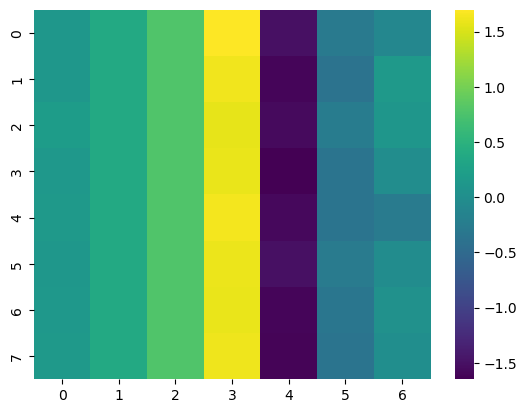

In [17]:
plt.figure()
sns.heatmap(np.reshape(action_dppo, (-1, 7)), cmap='viridis')
plt.show()

plt.figure()
sns.heatmap(np.reshape(action_dp, (-1, 7)), cmap='viridis')
plt.show()